# End-to-End Lane Navigation via Nvidia Model
Author: Muhammad Naufil, Faiz Hashmi, Haziq, Danish

Date: 2020-07-12

This is model training of FYP-02 Seld Driving Car, NED University.

Acknowledgement: This is model training portion of [DeepPiCar - Part 5: Autonomous Lane Navigation via Deep Learning](https://medium.com/@dctian/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110?source=your_stories_page---------------------------) Blog.   Please check out that blog for the full explanation of the code below. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
ls

gdrive/  sample_data/


In [7]:
cd 'gdrive/My Drive/fyp_dataset/training'

/content/gdrive/My Drive/fyp_dataset/training


In [3]:
#################### SEND ALERT EMAIL AT FINISH WITH GMAIL #####################
# To send email from Python from your google account, MUST 
# 1) Enable less secure app
# https://myaccount.google.com/lesssecureapps
# 2) Disable Unlock Capcha
# https://accounts.google.com/b/0/DisplayUnlockCaptcha
import smtplib

def SendEmail(msg):
    # store gmail password in my google drive (not the most secure way)
    # but it is much safer than storing it directly in this notebook, 
    # and upload it to github for everyone to see
    with open('/content/gdrive/My Drive/Colab Notebooks/pw.txt') as file:
        data = file.readlines()
    gmail_user = 'm.naufil1@gmail.com'  
    gmail_password = data[0]

    sent_from = gmail_user  
    to = ['naufil3906550@cloud.neduet.edu.pk']  
    subject = msg  
    body = '%s\n\n- Naufil' % msg

    email_text = \
"""From: %s
To: %s
Subject: %s

%s
""" % (sent_from, ", ".join(to), subject, body)

    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.ehlo()
    server.starttls()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, email_text)
    server.quit()

    print(f'Email: \n{email_text}')

## Imports Packages

In [4]:
# imports

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


Using TensorFlow backend.


tf.__version__: 2.2.0
keras.__version__: 2.3.1


In [8]:
ls

'hey (1).mp4_787_136.png'
'hey (1).mp4_788_135.png'
'hey (1).mp4_789_134.png'
'hey (1).mp4_790_133.png'
'hey (1).mp4_791_132.png'
'hey (1).mp4_792_131.png'
'hey (1).mp4_793_130.png'
'hey (1).mp4_794_129.png'
'hey (1).mp4_795_128.png'
'hey (1).mp4_796_123.png'
 hey.mp4_000_093.png
 hey.mp4_001_093.png
 hey.mp4_002_092.png
 hey.mp4_003_093.png
 hey.mp4_004_092.png
 hey.mp4_005_093.png
 hey.mp4_006_093.png
 hey.mp4_007_094.png
 hey.mp4_008_093.png
 hey.mp4_009_093.png
 hey.mp4_010_092.png
 hey.mp4_011_092.png
 hey.mp4_012_092.png
 hey.mp4_013_092.png
 hey.mp4_014_092.png
 hey.mp4_015_090.png
 hey.mp4_016_090.png
 hey.mp4_017_090.png
 hey.mp4_018_088.png
 hey.mp4_019_088.png
 hey.mp4_020_089.png
 hey.mp4_021_086.png
 hey.mp4_022_085.png
 hey.mp4_023_088.png
 hey.mp4_024_089.png
 hey.mp4_025_090.png
 hey.mp4_026_090.png
 hey.mp4_027_090.png
 hey.mp4_028_090.png
 hey.mp4_029_092.png
 hey.mp4_030_092.png
 hey.mp4_031_091.png
 hey.mp4_032_090.png
 hey.mp4_033_089.png
 hey.mp4_034_087.png
 hey.

## Load Train Data

13477
image_path: ./hey.mp4_1394_111.png
steering_Angle: 111


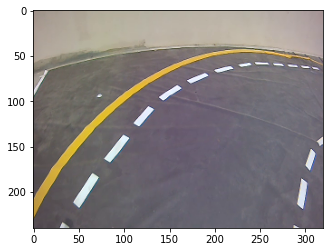

In [10]:
# import images
data_dir = './'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])  # 092 part of video01_143_092.png is the angle. 90 is go straight
        steering_angles.append(angle)

# added few examples
print(len(image_paths))
image_paths = image_paths[9000:13477]
steering_angles = steering_angles[9000:13477]
############
image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles


In [11]:
print(image_paths)

['./hey.mp4_1363_084.png', './hey.mp4_1364_084.png', './hey.mp4_1368_092.png', './hey.mp4_1360_085.png', './hey.mp4_1367_090.png', './hey.mp4_1374_103.png', './hey.mp4_1377_106.png', './hey.mp4_1376_105.png', './hey.mp4_1379_108.png', './hey.mp4_1378_107.png', './hey.mp4_1375_104.png', './hey.mp4_1382_105.png', './hey.mp4_1373_103.png', './hey.mp4_1372_101.png', './hey.mp4_1381_104.png', './hey.mp4_1380_103.png', './hey.mp4_1395_112.png', './hey.mp4_1391_108.png', './hey.mp4_1386_103.png', './hey.mp4_1385_102.png', './hey.mp4_1394_111.png', './hey.mp4_1383_100.png', './hey.mp4_1393_110.png', './hey.mp4_1384_101.png', './hey.mp4_1389_106.png', './hey.mp4_1396_113.png', './hey.mp4_1390_107.png', './hey.mp4_1388_105.png', './hey.mp4_1387_104.png', './hey.mp4_1397_114.png', './hey.mp4_1392_109.png', './hey.mp4_1410_127.png', './hey.mp4_1402_119.png', './hey.mp4_1405_122.png', './hey.mp4_1413_130.png', './hey.mp4_1401_118.png', './hey.mp4_1398_115.png', './hey.mp4_1406_123.png', './hey.mp4_

In [12]:
print(steering_angles)

[84, 84, 92, 85, 90, 103, 106, 105, 108, 107, 104, 105, 103, 101, 104, 103, 112, 108, 103, 102, 111, 100, 110, 101, 106, 113, 107, 105, 104, 114, 109, 127, 119, 122, 130, 118, 115, 123, 121, 120, 131, 129, 124, 132, 125, 116, 126, 128, 117, 137, 134, 132, 133, 134, 133, 135, 133, 136, 136, 134, 133, 132, 135, 134, 134, 127, 107, 93, 96, 90, 92, 93, 90, 102, 90, 112, 91, 94, 117, 97, 122, 101, 102, 92, 92, 93, 91, 95, 98, 100, 94, 97, 96, 99, 118, 117, 115, 113, 110, 109, 106, 104, 116, 105, 119, 111, 120, 108, 103, 107, 112, 114, 126, 123, 122, 129, 130, 130, 124, 121, 127, 125, 128, 125, 115, 111, 97, 108, 109, 105, 106, 120, 97, 110, 105, 99, 104, 109, 100, 95, 98, 90, 86, 89, 83, 97, 96, 97, 83, 89, 85, 92, 91, 85, 87, 92, 94, 87, 94, 89, 86, 91, 88, 92, 85, 91, 94, 91, 90, 89, 92, 93, 92, 94, 95, 90, 92, 93, 94, 92, 92, 91, 90, 95, 92, 93, 95, 94, 96, 90, 92, 94, 92, 94, 96, 93, 96, 94, 93, 95, 91, 95, 96, 98, 93, 89, 90, 91, 92, 93, 89, 92, 91, 91, 90, 92, 90, 90, 90, 90, 90, 90, 

(array([12.0000, 51.0000, 59.0000, 337.0000, 234.0000, 533.0000, 291.0000,
        378.0000, 303.0000, 174.0000, 239.0000, 146.0000, 221.0000,
        125.0000, 180.0000, 108.0000, 153.0000, 150.0000, 105.0000,
        161.0000, 111.0000, 183.0000, 106.0000, 106.0000, 11.0000]),
 array([76.0000, 78.5600, 81.1200, 83.6800, 86.2400, 88.8000, 91.3600,
        93.9200, 96.4800, 99.0400, 101.6000, 104.1600, 106.7200, 109.2800,
        111.8400, 114.4000, 116.9600, 119.5200, 122.0800, 124.6400,
        127.2000, 129.7600, 132.3200, 134.8800, 137.4400, 140.0000]),
 <a list of 25 Patch objects>)

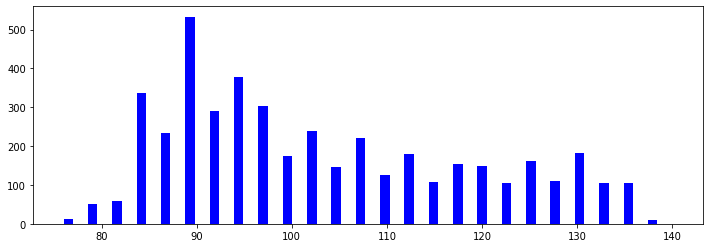

In [13]:
# Look at the distribution of steering angle
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Notice that the above diagram contains angeles mostly 90. This makes sense, because in our training data, The car was mostly going straight.

Training data: 3581
Validation data: 896


Text(0.5, 1.0, 'Validation Data')

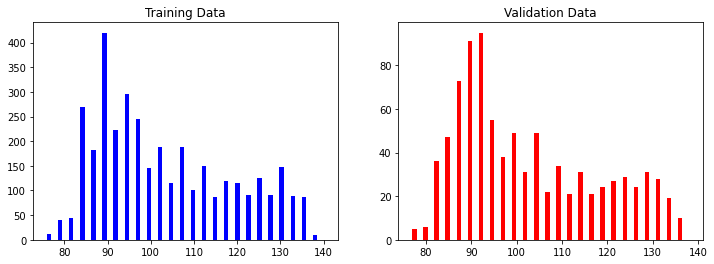

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')


##Image Augumentation
Since we only have a few hundred images, to train a deep network, we need a lot more images.   Instead of running our car, let's try to augment our data. There are a couple of ways to do that.

1. Zoom: crop out a smaller image from the center
1. Pan: crop out a smaller image from left or right side
1. adjust brightness of the image
1. flip the image horizontally, i.e do a left to right flip, and change the steering angle coorespondingly
1. introduce an Gaussian blur

We can combine the above augmentation techniques to generate 100s times of the training images, with just a few hundred real images.



Text(0.5, 1.0, 'zoomed')

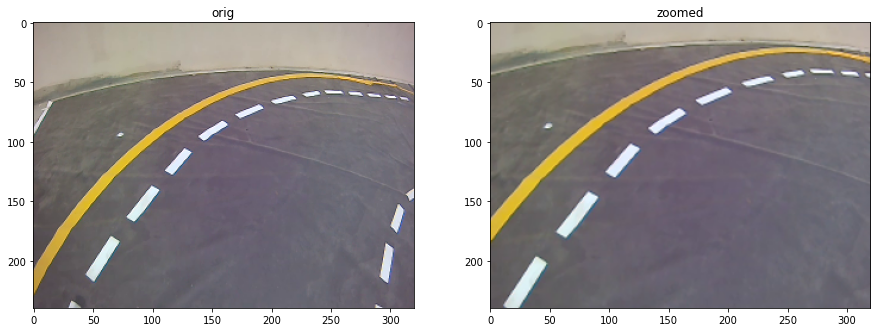

In [15]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")


Text(0.5, 1.0, 'panned')

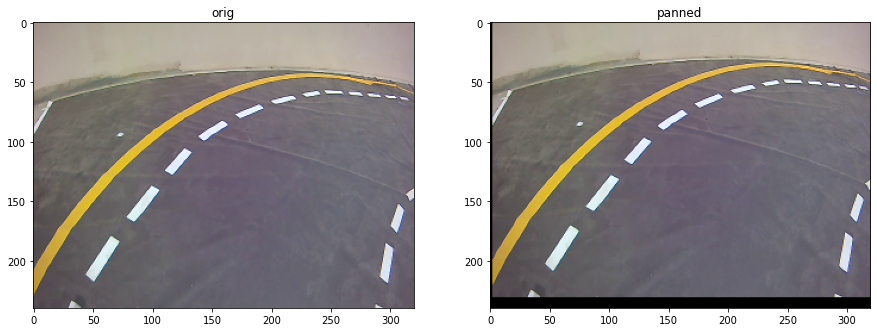

In [16]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_pan)
axes[1].set_title("panned")


Text(0.5, 1.0, 'brightness adjusted')

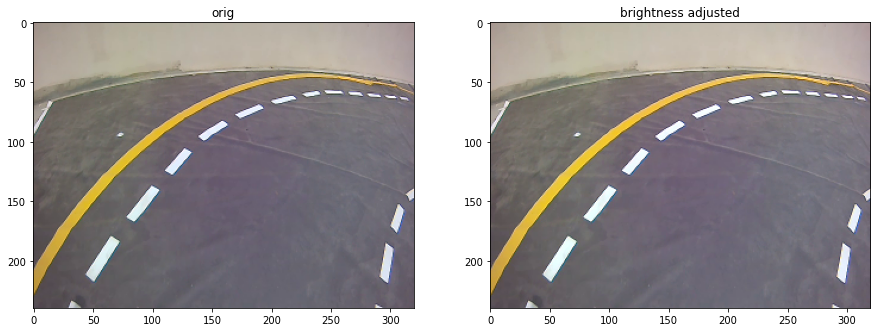

In [17]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

Text(0.5, 1.0, 'blurred')

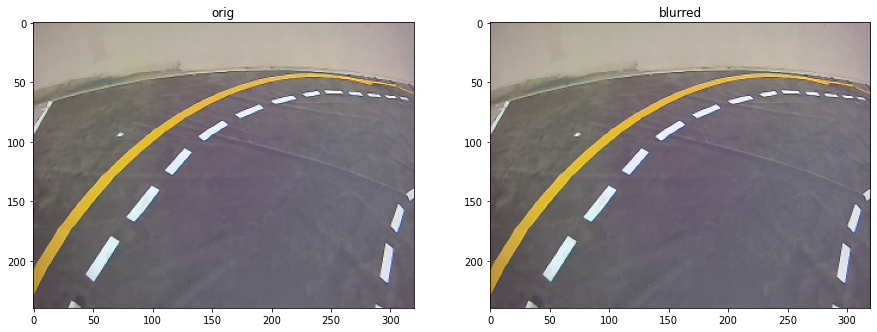

In [18]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

Text(0.5, 1.0, 'flipped, angle=111')

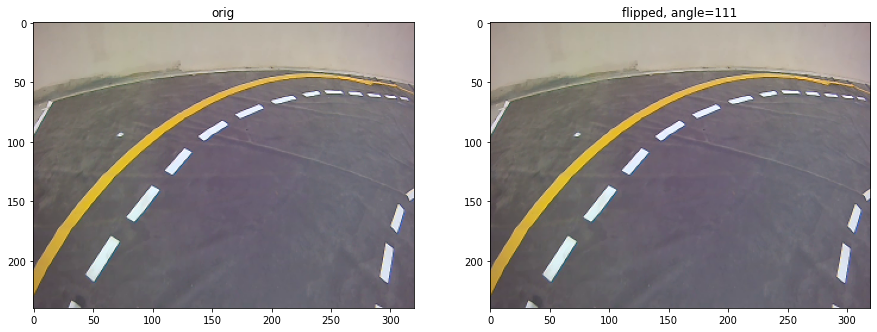

In [19]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        steering_angle = 180 - steering_angle
   
    return image, steering_angle

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_flip, steering_angle = random_flip(image_orig, steering_angles[image_index])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, angle=%s" % steering_angle)

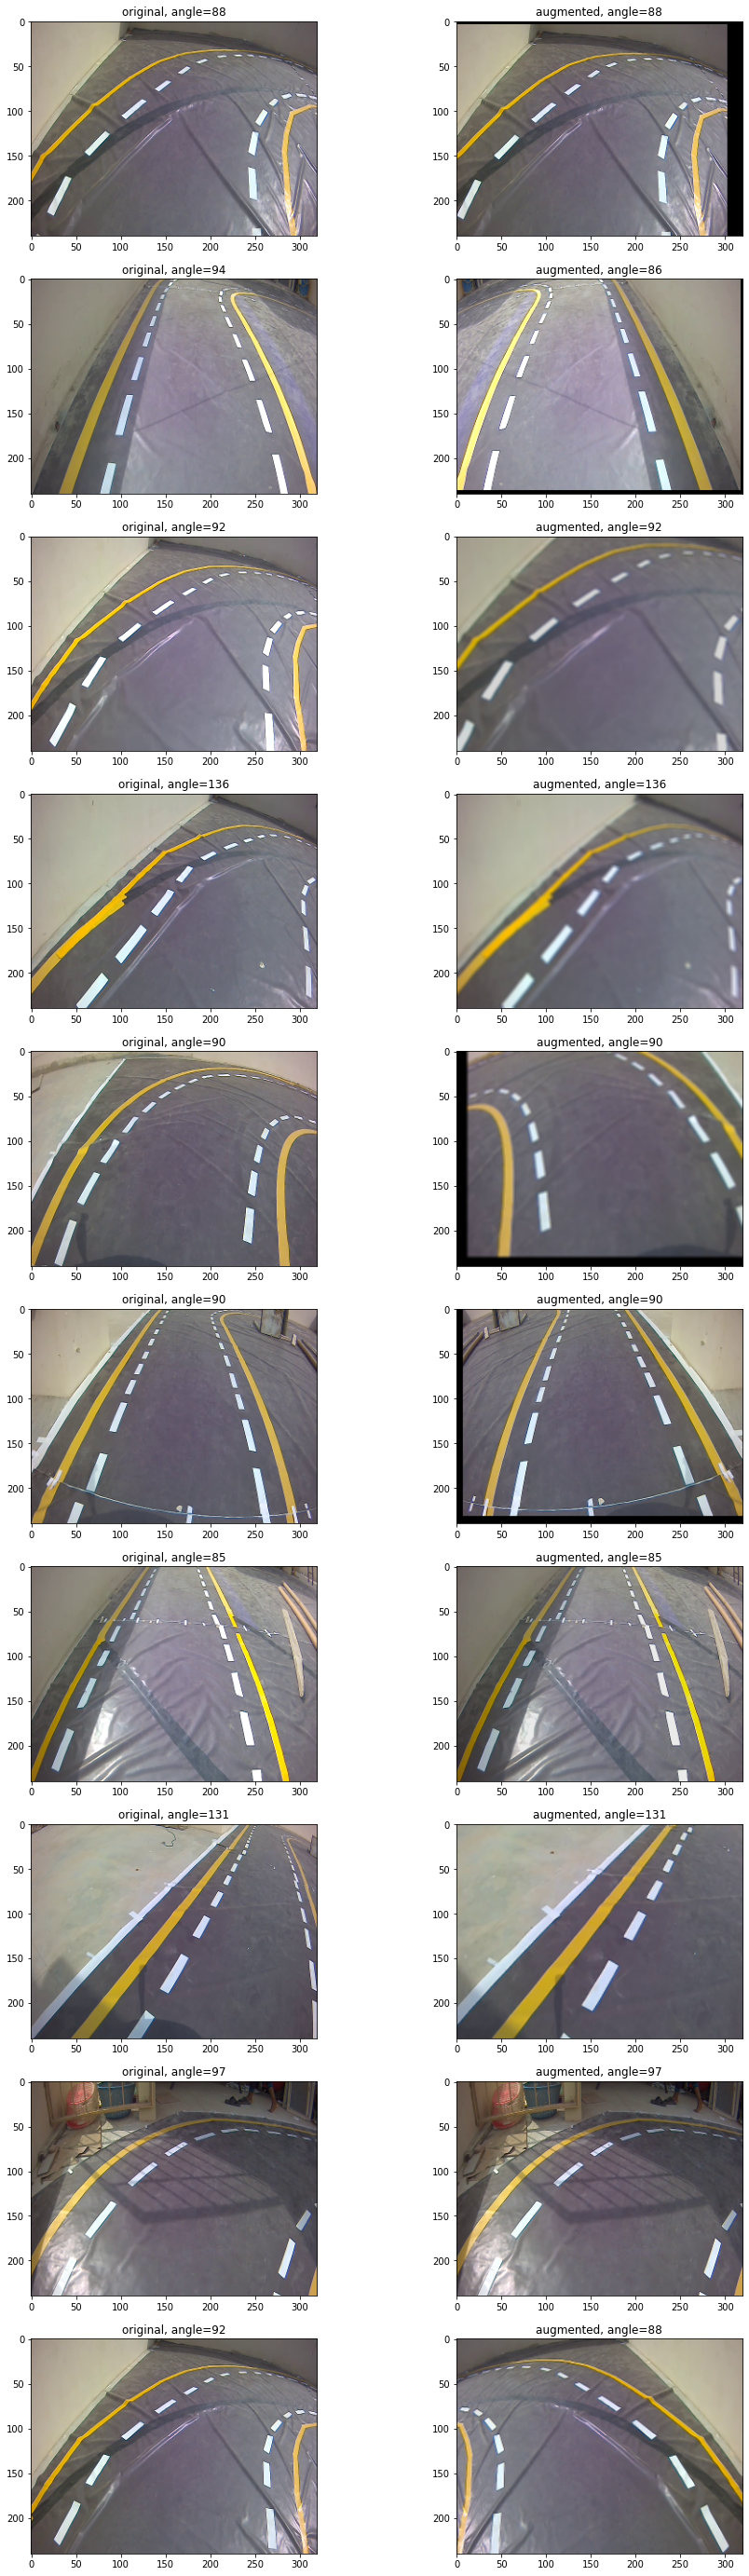

In [20]:
# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

# show a few randomly augmented images
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(image_paths) - 1)
    image_path = image_paths[rand_index]
    steering_angle_orig = steering_angles[rand_index]
    
    image_orig = my_imread(image_path)
    image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)
    
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)
    

## Preprocess Training Data for Nvidia Model

Text(0.5, 1.0, 'processed')

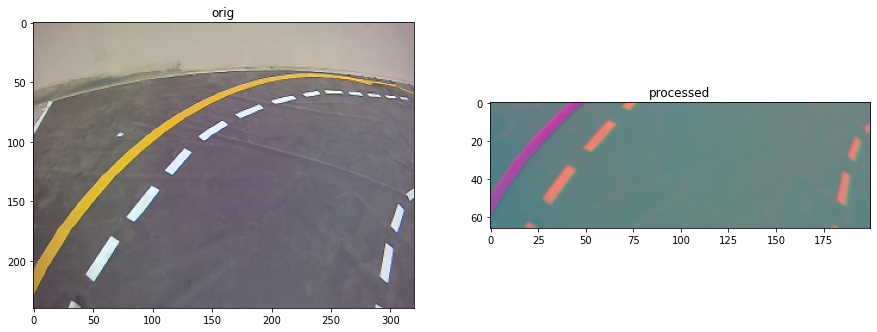

In [21]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")


## Create and Train Model

This is the Nvidia CNN Model Architecture. The input layer is at the bottom with size of 200x66 in YUV color space ![](https://github.com/dctian/DeepPiCar/raw/master/models/lane_navigation/doc/NVidia%20Model%20Architecture.JPG) .



In [22]:
# def nvidia_model():
#     model = Sequential(name='Nvidia_Model')
    
#     # elu=Expenential Linear Unit, similar to leaky Relu
#     # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
#     # Convolution Layers
#     model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
#     model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
#     model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
#     model.add(Conv2D(64, (3, 3), activation='elu')) 
#     model.add(Dropout(0.2)) # not in original model. added for more robustness
#     model.add(Conv2D(64, (3, 3), activation='elu')) 
    
#     # Fully Connected Layers
#     model.add(Flatten())
#     model.add(Dropout(0.2)) # not in original model. added for more robustness
#     model.add(Dense(100, activation='elu'))
#     model.add(Dense(50, activation='elu'))
#     model.add(Dense(10, activation='elu'))
    
#     # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
#     model.add(Dense(1)) 
    
#     # since this is a regression problem not classification problem,
#     # we use MSE (Mean Squared Error) as loss function
#     optimizer = Adam(lr=1e-3) # lr is learning rate
#     model.compile(loss='mse', optimizer=optimizer)
    
#     return model

In [23]:
# model = nvidia_model()
# print(model.summary())
# # check at we will have 252,219 trainable parameters

In [24]:
from keras.models import load_model

# load model
model = load_model('output/lane_navigation_final.h5')
model.summary()

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [25]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))
            
            

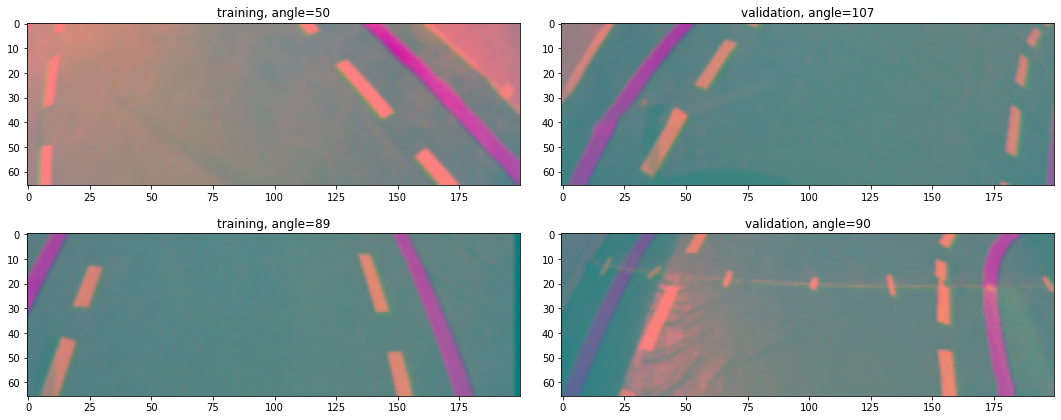

In [26]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])


In [27]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

# clean up log folder for tensorboard
log_dir_root = f'./output/logs'
#!rm -rf $log_dir_root


In [ ]:
# this block prevents the training from starting if we Run All
DO_NOT_RUN_ALL

In [28]:
# saves the model weights after each epoch if the validation loss decreased
model_output_dir = "./output"
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

SendEmail("lane nav train started")
history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=20,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history ' + date_str+ '.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    
SendEmail("lane nav train finished. val_loss from %.1f to %.1f" % (history.history['val_loss'][0], history.history['val_loss'][-1]))


Email: 
From: m.naufil1@gmail.com
To: naufil3906550@cloud.neduet.edu.pk
Subject: lane nav train started

lane nav train started

- Naufil

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


300/300 [==============================] - 1920s 6s/step - loss: 27.8351 - val_loss: 22.3819

Epoch 00001: val_loss improved from inf to 22.38191, saving model to ./output/lane_navigation_check.h5
Epoch 2/20
300/300 [==============================] - 456s 2s/step - loss: 22.7237 - val_loss: 14.0842

Epoch 00002: val_loss improved from 22.38191 to 14.08417, saving model to ./output/lane_navigation_check.h5
Epoch 3/20
300/300 [==============================] - 454s 2s/step - loss: 20.7767 - val_loss: 12.7402

Epoch 00003: val_loss improved from 14.08417 to 12.74016, saving model to ./output/lane_navigation_check.h5
Epoch 4/20
300/300 [==============================] - 454s 2s/step - loss: 19.8050 - val_loss: 19.8345

Epoch 00004: val_loss did not improve from 12.74016
Epoch 5/20
300/300 [==============================] - 454s 2s/step - loss: 19.7772 - val_loss: 12.1472

Epoch 00005: val_loss improved from 12.74016 to 12.14716, saving model to ./output/lane_navigation_check.h5
Epoch 6/20


## Check Trained Model on Validation Data

In [29]:
history.history


{'loss': [27.835107170740763,
  22.7237167930603,
  20.7766979376475,
  19.80502332051595,
  19.77716158866882,
  18.868831443786622,
  18.79957404454549,
  17.608534825642902,
  17.989070431391397,
  17.101642163594565,
  16.492685915629067,
  16.246589879989624,
  15.908856217066447,
  16.995083605448404,
  15.83886828104655,
  15.580731927553813,
  15.38490073521932,
  14.736752637227376,
  15.037755559285483,
  14.72495279788971],
 'val_loss': [22.381908416748047,
  14.08416748046875,
  12.740161895751953,
  19.834497451782227,
  12.147159576416016,
  15.542808532714844,
  12.285749435424805,
  14.825408935546875,
  12.625715255737305,
  10.307099342346191,
  11.188850402832031,
  12.848981857299805,
  10.67977523803711,
  12.61709976196289,
  10.97016716003418,
  12.411874771118164,
  9.47582721710205,
  9.219164848327637,
  10.484869003295898,
  9.758329391479492]}

In [30]:
# plot training and validation losses
# this should be the same as tensorboard
history_path = os.path.join(model_output_dir,'history ' + date_str + '.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

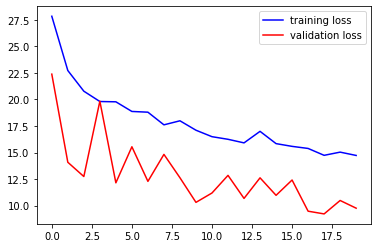

In [31]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [32]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_final.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

mse       = 1e+01
r_squared = 94.56%



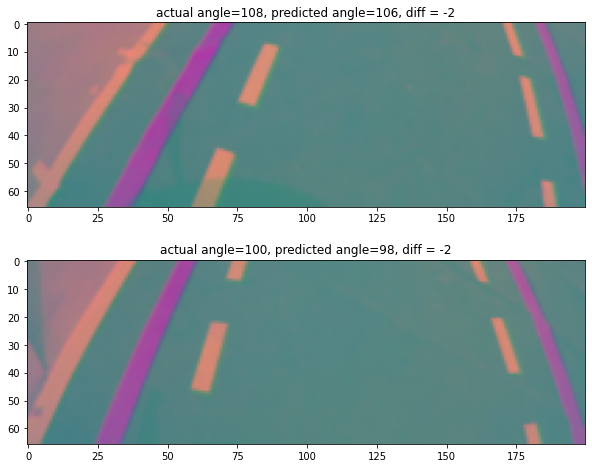

In [33]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")
    

As we can see the $R^2$ of the predicted was around 95% and Mean Squared Errors (MSE) are low, indicating the model is predicting a steering angle every simliar to our hand coded land follower, which was used as the model input. 

## References
1. Mariusz Bojarski, Davide Del Testa, Daniel Dworakowski, Bernhard Firner, Beat Flepp, Prasoon Goyal, Lawrence D. Jackel, Mathew Monfort, Urs Muller, Jiakai Zhang, Xin Zhang, Jake Zhao, Karol Zieba (2016) *End to End Learning for Self-Driving Cars*. Nvidia 
1. Rayan Slim, Amer Sharaf, Jad Slim (2017) *The Complete Self-Driving Car Course*. Udemy
1. Keras Documentation (2019) https://github.com/keras-team/keras/

